# Agents:
These simulations evaluate several agents exploring the thread the needle enviroment

In [20]:
%load_ext autoreload
%autoreload 2
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
%matplotlib inline
import sys
import torch
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, DQN, PPO
import matplotlib.pyplot as plt

from state_inference.gridworld_env import CnnWrapper, OpenEnv, ThreadTheNeedleEnv
from state_inference.utils.training_utils import train_model, parse_config
from state_inference.utils.pytorch_utils import DEVICE

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")


python 3.10.11 (main, Apr 20 2023, 13:58:42) [Clang 14.0.6 ]
torch 2.0.1
device = mps


In [22]:
CONFIG_FILE = "state_inference/env_config.yml"
TASK_NAME = "thread_the_needle"
TASK_CLASS = OpenEnv

In [23]:
env_kwargs, training_kwargs = parse_config(TASK_NAME, CONFIG_FILE)

training_kwargs["n_train_steps"] = 50000
training_kwargs["n_epochs"] = 1

# create the task
task = CnnWrapper(TASK_CLASS.create_env(**env_kwargs))

pi, _ = task.get_optimal_policy()
training_kwargs["optimal_policy"] = pi

  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: title={'center': 'Thread-the-needle states'}>

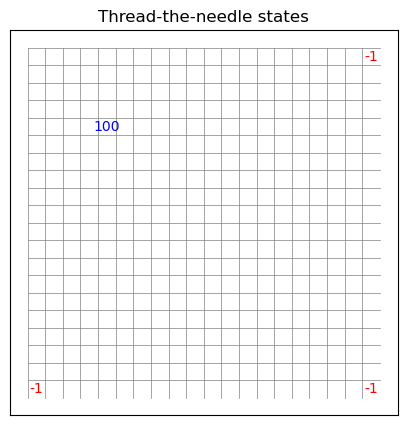

In [24]:
task.display_gridworld()

In [5]:
ppo = PPO("CnnPolicy", task, verbose=0)
ppo.learn(total_timesteps=training_kwargs["n_train_steps"], progress_bar=False)

In [6]:
env_kwargs

{'height': 20,
 'width': 20,
 'map_height': 40,
 'state_rewards': {84: 100, 399: -1, 19: -1, 380: -1},
 'end_state': [84, 399, 19, 380],
 'movement_penalty': -0.1,
 'n_states': 400,
 'observation_kwargs': {'rbf_kernel_size': 31,
  'rbf_kernel_scale': 0.35,
  'location_noise_scale': 0.25,
  'noise_log_mean': -3,
  'noise_log_scale': 0.05,
  'noise_corruption_prob': 0.005}}

In [7]:
from state_inference.utils.training_utils import sample_policy

pi_hat, _ = sample_policy(
    ppo, n_states=env_kwargs["n_states"], map_height=env_kwargs["map_height"], cnn=True
)

Text(0.5, 1.0, 'right')

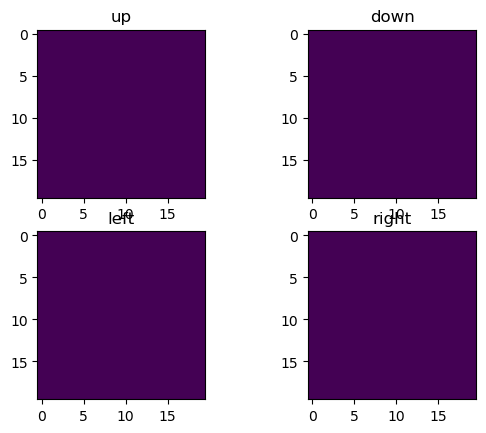

In [8]:
fig, axes = plt.subplots(2, 2)
h, w = env_kwargs["height"], env_kwargs["width"]
axes[0][0].imshow(pi_hat.reshape(h, w) == 0)
axes[0][1].imshow(pi_hat.reshape(h, w) == 1)
axes[1][0].imshow(pi_hat.reshape(h, w) == 2)
axes[1][1].imshow(pi_hat.reshape(h, w) == 3)


axes[0][0].set_title("up")
axes[0][1].set_title("down")
axes[1][0].set_title("left")
axes[1][1].set_title("right")

In [9]:
from state_inference.utils.training_utils import get_policy_prob

pmf = get_policy_prob(
    ppo, n_states=env_kwargs["n_states"], map_height=env_kwargs["map_height"], cnn=True
)

Text(0.5, 0.98, 'PPO Learned Policy')

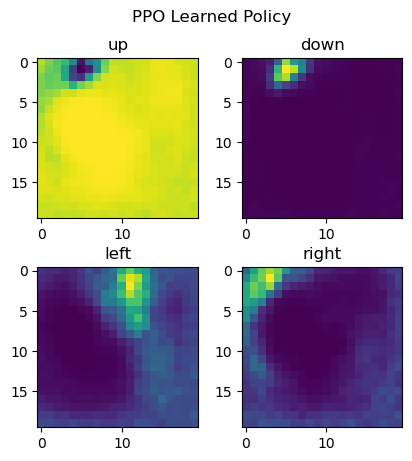

In [10]:
import seaborn as sns

fig, axes = plt.subplots(2, 2)

axes[0][0].imshow(pmf[:, 0].reshape(h, w))
axes[0][1].imshow(pmf[:, 1].reshape(h, w))
axes[1][0].imshow(pmf[:, 2].reshape(h, w))
axes[1][1].imshow(pmf[:, 3].reshape(h, w))


axes[0][0].set_title("up")
axes[0][1].set_title("down")
axes[1][0].set_title("left")
axes[1][1].set_title("right")

plt.subplots_adjust(hspace=0.3, wspace=-0.3)

plt.suptitle("PPO Learned Policy")

Text(0.5, 0.98, 'Optimal Policy')

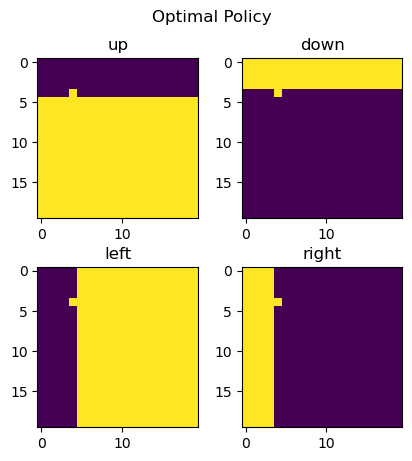

In [11]:
fig, axes = plt.subplots(2, 2)

axes[0][0].imshow(pi[:, 0].reshape(h, w))
axes[0][1].imshow(pi[:, 1].reshape(h, w))
axes[1][0].imshow(pi[:, 2].reshape(h, w))
axes[1][1].imshow(pi[:, 3].reshape(h, w))


axes[0][0].set_title("up")
axes[0][1].set_title("down")
axes[1][0].set_title("left")
axes[1][1].set_title("right")
plt.subplots_adjust(hspace=0.3, wspace=-0.3)

plt.suptitle("Optimal Policy")

In [12]:
np.sum(pi * pmf, axis=1).mean()

0.7526684390594311

In [13]:
from state_inference.utils.training_utils import score_policy

score_policy(
    ppo,
    pi,
    n_states=env_kwargs["n_states"],
    map_height=env_kwargs["map_height"],
    cnn=True,
)

0.7526407664364766

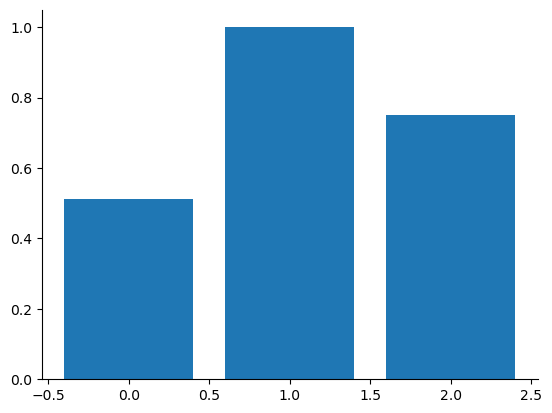

In [14]:
room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10

score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()
plt.bar([0, 1, 2], [score_room_1, score_room_2, score_room_3])

sns.despine()

In [15]:
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)

np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()

0.9998187988649057

In [16]:
np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()

0.7497905270490173

In [17]:
from tqdm import trange

## Repeat with iterations
n_models = 50


room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10


scores = []


for idx in trange(n_models):
    ppo = PPO("CnnPolicy", task, verbose=0)
    ppo.learn(total_timesteps=training_kwargs["n_train_steps"], progress_bar=False)

    pmf = get_policy_prob(
        ppo,
        n_states=env_kwargs["n_states"],
        map_height=env_kwargs["map_height"],
        cnn=True,
    )

    score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
    score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
    score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()

    scores.append(
        pd.DataFrame(
            {
                "Iteration": [idx] * 4,
                "Score": [
                    np.sum(pi * pmf, axis=1).mean(),
                    score_room_1,
                    score_room_2,
                    score_room_3,
                ],
                "Condition": ["Overall", "Room 1", "Room 2", "Room 3"],
            }
        )
    )

scores = pd.concat(scores)

100%|██████████| 50/50 [3:11:54<00:00, 230.29s/it]  


In [18]:
scores.to_csv("sims_thread_the_needle_no_walls.csv")

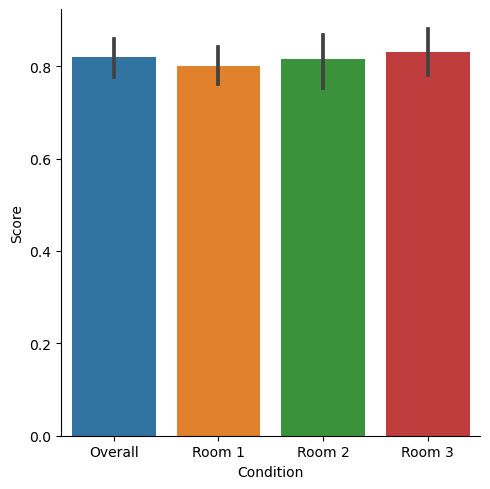

In [19]:
sns.catplot(data=scores, y="Score", x="Condition", kind="bar")